In [ ]:
Hakobyan Marta_ midterm task

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

Analyze the data

In [118]:
#Read data
spark = SparkSession.builder.appName("midterm").getOrCreate()

transactions = spark.read.csv("transactions-2p-42.csv", header=True, inferSchema=True)
articles = spark.read.csv("articles.csv", header=True, inferSchema=True)

transactions.show(5)
articles.show(5)


+----------+--------------------+----------+------------------+----------------+
|     t_dat|         customer_id|article_id|             price|sales_channel_id|
+----------+--------------------+----------+------------------+----------------+
|2019-07-24|192e9ad7f0c05d89e...| 692721005|0.0121864406779661|               2|
|2019-04-07|70c1ee207c64a6523...| 599502013|0.0508305084745762|               2|
|2019-05-21|e29656435a0c04ef1...| 737260001|0.0254067796610169|               2|
|2019-03-29|13d1fd878959e117e...| 717251003|0.0169322033898305|               2|
|2019-07-05|58ddbcfa96eab2b3a...| 795675003| 0.008457627118644|               1|
+----------+--------------------+----------+------------------+----------------+
only showing top 5 rows
+----------+------------+-----------------+---------------+-----------------+------------------+-----------------------+-------------------------+-----------------+-----------------+-------------------------+---------------------------+-----------

In [24]:
#get month season and year
transactions = transactions.withColumn("date", F.to_date("t_dat"))
transactions = transactions.withColumn("month", F.month("date"))

transactions.select("t_dat", "date", "month").show(5)



+----------+----------+-----+
|     t_dat|      date|month|
+----------+----------+-----+
|2019-07-24|2019-07-24|    7|
|2019-04-07|2019-04-07|    4|
|2019-05-21|2019-05-21|    5|
|2019-03-29|2019-03-29|    3|
|2019-07-05|2019-07-05|    7|
+----------+----------+-----+
only showing top 5 rows


In [16]:
def season_from_month(month_col):
    return (
        F.when(month_col.isin(12,1,2), "Winter")
         .when(month_col.isin(3,4,5), "Spring")
         .when(month_col.isin(6,7,8), "Summer")
         .when(month_col.isin(9,10,11), "Autumn")
         .otherwise("Unknown")
    )

transactions = transactions.withColumn("season", season_from_month(F.col("month")))
transactions.select("date", "month", "season").show(10)



+----------+-----+------+
|      date|month|season|
+----------+-----+------+
|2019-07-24|    7|Summer|
|2019-04-07|    4|Spring|
|2019-05-21|    5|Spring|
|2019-03-29|    3|Spring|
|2019-07-05|    7|Summer|
|2019-06-04|    6|Summer|
|2018-10-05|   10|Autumn|
|2019-06-04|    6|Summer|
|2018-10-12|   10|Autumn|
|2019-06-08|    6|Summer|
+----------+-----+------+
only showing top 10 rows


In [22]:


df = df.withColumn("year", F.year("date"))

df.select("t_dat", "date", "year", "month", "season").show(5)

+----------+----------+----+-----+------+
|     t_dat|      date|year|month|season|
+----------+----------+----+-----+------+
|2019-07-24|2019-07-24|2019|    7|Summer|
|2019-04-07|2019-04-07|2019|    4|Spring|
|2019-05-21|2019-05-21|2019|    5|Spring|
|2019-03-29|2019-03-29|2019|    3|Spring|
|2019-07-05|2019-07-05|2019|    7|Summer|
+----------+----------+----+-----+------+
only showing top 5 rows


1. What are the product trend changes through 
    a. seasons of the year
    b. the years

In [164]:
#1.Seasonal trends at the product_group_name level
from pyspark.sql import Window

# # Demand by seasons and product groups (product_group_name)
season_pg = (
    df.groupBy("season", "product_group_name")
      .agg(
        F.sum("revenue").alias("total_revenue"),
        F.count("*").alias("transactions_count")
    )
      .orderBy("season", F.desc("total_revenue")))


season_pg.show(50, truncate=False)

+------+-------------------+--------------------+------------------+
|season|product_group_name |total_revenue       |transactions_count|
+------+-------------------+--------------------+------------------+
|Autumn|Garment Upper body |2103.9472033898282  |38625             |
|Autumn|Garment Lower body |1094.1012542372907  |18046             |
|Autumn|Garment Full body  |418.0038644067784   |5972              |
|Autumn|Underwear          |204.55950847457603  |5523              |
|Autumn|Shoes              |164.24862711864395  |1932              |
|Autumn|Accessories        |126.2438644067794   |4514              |
|Autumn|Swimwear           |51.27098305084732   |1576              |
|Autumn|Nightwear          |49.10040677966091   |1035              |
|Autumn|Socks & Tights     |39.15596610169481   |2228              |
|Autumn|Unknown            |1.966864406779657   |48                |
|Autumn|Bags               |0.6922372881355918  |10                |
|Autumn|Underwear/nightwear|0.1355

In [38]:
#Top 5 product groups in each season
#We add ranks and retain the top 5 revenue groups for each season.
w_season_pg = Window.partitionBy("season").orderBy(F.desc("total_revenue"))


season_pg_top5 = (
    season_pg
      .withColumn("rank", F.row_number().over(w_season_pg))
      .filter(F.col("rank") <= 5)
)

season_pg_top5.show(50, truncate=False)



+------+------------------+------------------+------------------+----+
|season|product_group_name|total_revenue     |transactions_count|rank|
+------+------------------+------------------+------------------+----+
|Autumn|Garment Upper body|2103.9472033898282|38625             |1   |
|Autumn|Garment Lower body|1094.1012542372907|18046             |2   |
|Autumn|Garment Full body |418.0038644067784 |5972              |3   |
|Autumn|Underwear         |204.55950847457603|5523              |4   |
|Autumn|Shoes             |164.24862711864395|1932              |5   |
|Spring|Garment Upper body|1346.7726101694896|31380             |1   |
|Spring|Garment Lower body|1171.5116610169491|19326             |2   |
|Spring|Garment Full body |780.6370508474566 |10568             |3   |
|Spring|Swimwear          |468.77983050847604|10305             |4   |
|Spring|Underwear         |213.3209322033897 |6033              |5   |
|Summer|Garment Upper body|1186.413254237283 |34216             |1   |
|Summe

Example of trends by other attributes 

In [54]:
# Example of trends by product type
season_ptype = (
    df.groupBy("season", "product_type_name")
      .agg(F.sum("revenue").alias("total_revenue"))
)

w = Window.partitionBy("season").orderBy(F.desc("total_revenue"))

season_ptype_top5 = (
    season_ptype
      .withColumn("rank", F.row_number().over(w))
      .filter(F.col("rank") <= 5)
      .orderBy("season", "rank")
)

season_ptype_top5.show(50, truncate=False)



+------+-----------------+------------------+----+
|season|product_type_name|total_revenue     |rank|
+------+-----------------+------------------+----+
|Autumn|Trousers         |820.8658135593197 |1   |
|Autumn|Sweater          |735.5534237288113 |2   |
|Autumn|Dress            |386.84350847457506|3   |
|Autumn|Jacket           |324.65952542372855|4   |
|Autumn|Blouse           |198.12167796610126|5   |
|Spring|Trousers         |723.9163559322008 |1   |
|Spring|Dress            |714.6475084745747 |2   |
|Spring|Blouse           |258.62847457627043|3   |
|Spring|Bikini top       |209.55550847457607|4   |
|Spring|Shorts           |186.40411864406755|5   |
|Summer|Dress            |724.8365762711861 |1   |
|Summer|Trousers         |585.2111355932186 |2   |
|Summer|Shorts           |292.3437796610169 |3   |
|Summer|Blouse           |224.48218644067737|4   |
|Summer|Bikini top       |218.63598305084696|5   |
|Winter|Trousers         |670.0962542372866 |1   |
|Winter|Sweater          |443.3

In [56]:
# Example of trends by department_name

season_dept = (
    df.groupBy("season", "department_name")
      .agg(F.sum("revenue").alias("total_revenue"))
)

w = Window.partitionBy("season").orderBy(F.desc("total_revenue"))

season_dept_top5 = (
    season_dept
      .withColumn("rank", F.row_number().over(w))
      .filter(F.col("rank") <= 5)
      .orderBy("season", "rank")
)

season_dept_top5.show(50, truncate=False)



+------+---------------+------------------+----+
|season|department_name|total_revenue     |rank|
+------+---------------+------------------+----+
|Autumn|Knitwear       |464.68518644067495|1   |
|Autumn|Trouser        |289.379033898304  |2   |
|Autumn|Outwear        |256.2661355932202 |3   |
|Autumn|Blouse         |166.66723728813517|4   |
|Autumn|Denim Trousers |164.80174576271168|5   |
|Spring|Swimwear       |446.8943050847474 |1   |
|Spring|Trouser        |303.32876271186353|2   |
|Spring|Dress          |284.7161186440667 |3   |
|Spring|Jersey         |263.15698305084703|4   |
|Spring|Blouse         |233.7305932203384 |5   |
|Summer|Swimwear       |477.8318644067815 |1   |
|Summer|Dress          |285.88196610169393|2   |
|Summer|Trouser        |265.5024067796605 |3   |
|Summer|Blouse         |230.07227118644013|4   |
|Summer|Jersey         |220.3494745762708 |5   |
|Winter|Knitwear       |273.4696779661009 |1   |
|Winter|Trouser        |221.98303389830457|2   |
|Winter|Outwear     

In [58]:
# Example of trends by colour_group

season_dept = (
    df.groupBy("season", "colour_group_name")
      .agg(F.sum("revenue").alias("total_revenue"))
)

w = Window.partitionBy("season").orderBy(F.desc("total_revenue"))

season_dept_top5 = (
    season_dept
      .withColumn("rank", F.row_number().over(w))
      .filter(F.col("rank") <= 5)
      .orderBy("season", "rank")
)

season_dept_top5.show(50, truncate=False)


+------+-----------------+------------------+----+
|season|colour_group_name|total_revenue     |rank|
+------+-----------------+------------------+----+
|Autumn|Black            |1689.3568305084793|1   |
|Autumn|Dark Blue        |370.38688135593145|2   |
|Autumn|White            |233.40277966101647|3   |
|Autumn|Grey             |172.1101694915251 |4   |
|Autumn|Dark Red         |162.9441186440676 |5   |
|Spring|Black            |1326.8788305084718|1   |
|Spring|White            |494.7770677966098 |2   |
|Spring|Dark Blue        |382.6634067796605 |3   |
|Spring|Blue             |210.49605084745738|4   |
|Spring|Light Beige      |188.69720338983026|5   |
|Summer|Black            |1317.624406779655 |1   |
|Summer|White            |484.36884745762785|2   |
|Summer|Dark Blue        |340.74252542372875|3   |
|Summer|Light Beige      |225.37720338983027|4   |
|Summer|Blue             |194.1572203389828 |5   |
|Winter|Black            |1333.6800508474585|1   |
|Winter|Dark Blue        |321.9

2. Suggest a methodology and make an estimate for the whole data given that transactions.csv is a random sample of 3%
from the entire population (3 points). Estimate
    a. total revenue
    b. number of customers
    c. number of transactions
    d. average expenses per year per customer

In [61]:
k = 1 / 0.03   # 3% выборка
k

33.333333333333336

In [67]:
#Estimated total revenue, customers, transactionс
sample_revenue = df.agg(F.sum("revenue").alias("sample_revenue")).first()[0]
total_revenue_est = sample_revenue * k

sample_customers = df.select("customer_id").distinct().count()
total_customers_est = sample_customers * k

sample_transactions = df.count()
total_transactions_est = sample_transactions * k

print("Sample revenue:", sample_revenue)
print("Estimated TOTAL revenue:", total_revenue_est)
print("Sample customers:", sample_customers)
print("Estimated TOTAL customers:", total_customers_est)
print("Sample transactions:", sample_transactions)
print("Estimated TOTAL transactions:", total_transactions_est)

Sample revenue: 16107.338898305568
Estimated TOTAL revenue: 536911.2966101856
Sample customers: 230688
Estimated TOTAL customers: 7689600.000000001
Sample transactions: 336078
Estimated TOTAL transactions: 11202600.0


In [71]:
#5Average annual customer expenses, calculate the revenue of each customer in each year
customer_year_revenue = (
    df.groupBy("customer_id", "year")
      .agg(F.sum("revenue").alias("yearly_revenue"))
)

In [73]:
#average cost per client per year
avg_annual_spending = (
    customer_year_revenue.agg(F.avg("yearly_revenue"))
).first()[0]

print("Average annual spending per customer:", avg_annual_spending)


Average annual spending per customer: 0.06294043662443405


3. Report overall data quality (2 point) (nulls, mismatches in joins, outliers, any other valid data inconsistency)


In [90]:
#null report
def null_report(df, name):
    total = df.count()
    print(f"\n===== NULL REPORT: {name} (total rows = {total}) =====")
    exprs = [
        F.count(F.when(F.col(c).isNull(), c)).alias(c)
        for c in df.columns
    ]
    row = df.select(*exprs).first()
    for c in df.columns:
        n = row[c]
        if n > 0:
            print(f"{c}: {n} nulls ({n/total:.2%})")
 
    
null_report(transactions, "transactions")
null_report(articles, "articles")
null_report(df, "df (joined)")


===== NULL REPORT: transactions (total rows = 336078) =====

===== NULL REPORT: articles (total rows = 105542) =====
detail_desc: 416 nulls (0.39%)

===== NULL REPORT: df (joined) (total rows = 336078) =====
detail_desc: 1948 nulls (0.58%)


In [96]:
#transactions without a corresponding product in articles
missing_articles = transactions.join(articles, on="article_id", how="left_anti")
print("Transactions with article_id that does NOT exist in articles:", missing_articles.count())

# goods that never appear in transactions
unused_articles = articles.join(transactions, on="article_id", how="left_anti")
print("Articles that NEVER appear in transactions:", unused_articles.count())




Transactions with article_id that does NOT exist in articles: 0
Articles that NEVER appear in transactions: 64137


In [102]:
cols = ["price"]

for c in cols:
    q1, q99 = df.approxQuantile(c, [0.01, 0.99], 0.01)
    print(c, q1, q99)

    outliers = df.filter((F.col(c) < q1) | (F.col(c) > q99))
    print("Outliers count:", outliers.count())


price 0.0001864406779661 0.5067796610169492
Outliers count: 0


In [108]:
# negative or zero price
bad_price = df.filter(F.col("price") <= 0)
print("Rows with non-positive price:", bad_price.count())


if "revenue" in df.columns:
    bad_revenue = df.filter(F.col("revenue") <= 0)
    print("Rows with non-positive revenue:", bad_revenue.count())
   


Rows with non-positive price: 0
Rows with non-positive revenue: 0


In [110]:
total_rows = df.count()
distinct_rows = df.distinct().count()

print("Total rows in df:", total_rows)
print("Distinct rows in df:", distinct_rows)
print("Potential duplicate rows:", total_rows - distinct_rows)


Total rows in df: 336078
Distinct rows in df: 335151
Potential duplicate rows: 927


In [112]:
df.select(
    F.min("date").alias("min_date"),
    F.max("date").alias("max_date")
).show()


+----------+----------+
|  min_date|  max_date|
+----------+----------+
|2018-09-20|2019-09-19|
+----------+----------+



In [116]:
max_date = df.agg(F.max("date")).first()[0]

rfm = df.groupBy("customer_id") \
    .agg(
        F.max("date").alias("last_purchase"),
        F.count("*").alias("frequency"),
        F.sum("revenue").alias("monetary")
    ) \
    .withColumn("recency", F.datediff(F.lit(max_date), F.col("last_purchase")))

rfm.show(10)


+--------------------+-------------+---------+-------------------+-------+
|         customer_id|last_purchase|frequency|           monetary|recency|
+--------------------+-------------+---------+-------------------+-------+
|d4bececc5d92ce342...|   2019-04-28|        1| 0.0254067796610169|    144|
|4a55c9af71589dceb...|   2019-01-17|        5|0.18627118644067742|    245|
|a2ef0953a76ebadf6...|   2019-07-24|        1| 0.0135254237288134|     57|
|f51499ddde5a4af71...|   2019-01-21|        2|0.10840677966101661|    241|
|b7b6433f1368a8c2d...|   2019-07-21|        2| 0.1423050847457626|     60|
|3bbbb8e3f78f0bb36...|   2019-06-21|        1| 0.0236949152542372|     90|
|b10f43de2cdb36839...|   2019-01-10|        2| 0.1185762711864406|    252|
|490f8120b4764bdc7...|   2019-06-20|        1| 0.0677627118644066|     91|
|64bab5e85268ae2af...|   2018-12-02|        1| 0.9628813559322034|    291|
|51c3a45ec2f667685...|   2019-04-05|        3| 0.0524576271186438|    167|
+--------------------+---

Recency — quantity of days from the moment of the last purchase;
Frequency — number of transactions;
Monetary — total revenue brought by the client.

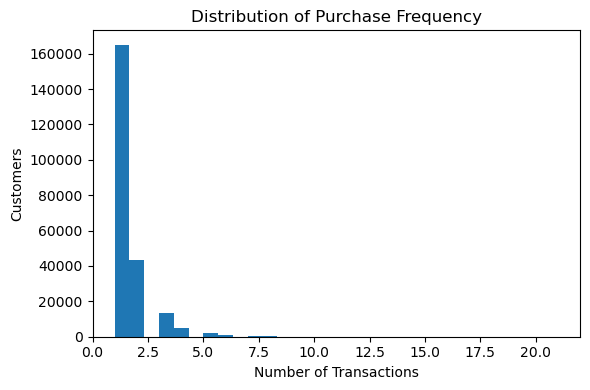

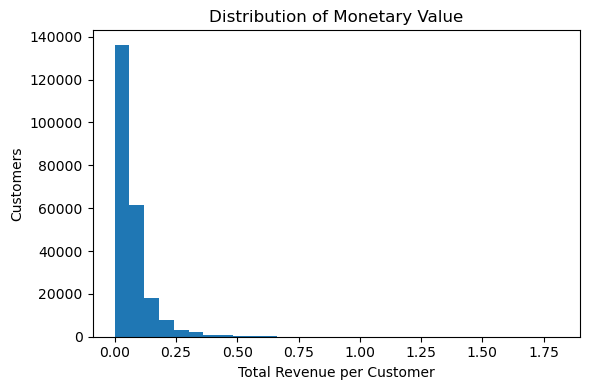

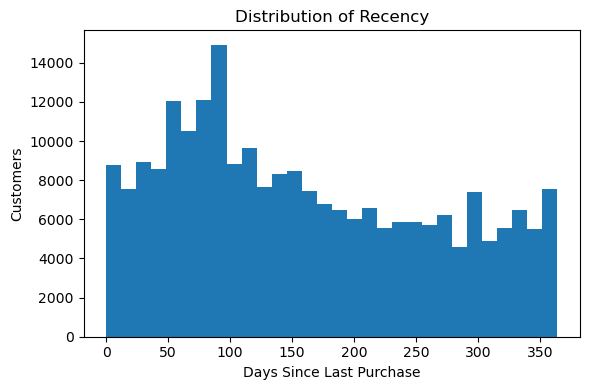

In [200]:
pdf = rfm.select("frequency", "monetary", "recency").toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(pdf["frequency"], bins=30)
plt.title("Distribution of Purchase Frequency")
plt.xlabel("Number of Transactions")
plt.ylabel("Customers")
plt.tight_layout()
plt.show()
plt.figure(figsize=(6,4))
plt.hist(pdf["monetary"], bins=30)
plt.title("Distribution of Monetary Value")
plt.xlabel("Total Revenue per Customer")
plt.ylabel("Customers")
plt.tight_layout()
plt.show()
plt.figure(figsize=(6,4))
plt.hist(pdf["recency"], bins=30)
plt.title("Distribution of Recency")
plt.xlabel("Days Since Last Purchase")
plt.ylabel("Customers")
plt.tight_layout()
plt.show()


4. More findings and creative work

ABC_XYZ class analize

In [130]:
#Revenue by product
product_revenue = (
    df.groupBy("article_id")
      .agg(F.sum("revenue").alias("total_revenue"))
)


In [132]:
#Cumulative share of income
w = Window.orderBy(F.desc("total_revenue"))

product_abc = (
    product_revenue
    .withColumn("revenue_share", F.col("total_revenue") / F.sum("total_revenue").over(Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)))
    .withColumn("cum_share", F.sum("revenue_share").over(w))
)


In [134]:
#Assignment of ABC classes
product_abc = product_abc.withColumn(
    "ABC",
    F.when(F.col("cum_share") <= 0.8, "A")
     .when(F.col("cum_share") <= 0.95, "B")
     .otherwise("C")
)


In [136]:
#X-Y analysis (demand stability)
product_monthly = (
    df.groupBy("article_id", "year", "month")
      .agg(F.sum("revenue").alias("monthly_revenue"))
)


In [144]:
#Mean and standard deviation
product_xy = (
    product_monthly.groupBy("article_id")
      .agg(
          F.avg("monthly_revenue").alias("mean_rev"),
          F.stddev("monthly_revenue").alias("std_rev")
      )
      .withColumn("cv", F.col("std_rev") / F.col("mean_rev"))
)


In [146]:
#X/Y/Z classes
product_xy = product_xy.withColumn(
    "XYZ",
    F.when(F.col("cv") <= 0.5, "X")
     .when(F.col("cv") <= 1.0, "Y")
     .otherwise("Z")
)


In [148]:
#Final
abc_xyz = (
    product_abc.join(product_xy, on="article_id")
               .withColumn("segment", F.concat(F.col("ABC"), F.lit("/"), F.col("XYZ")))
)

abc_xyz.groupBy("segment").count().orderBy("segment").show()


25/12/14 19:17:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/14 19:17:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/14 19:17:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/14 19:17:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/14 19:17:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/14 19:17:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/14 1

+-------+-----+
|segment|count|
+-------+-----+
|    A/X| 2961|
|    A/Y| 7129|
|    A/Z| 2122|
|    B/X| 5122|
|    B/Y| 4000|
|    B/Z| 2995|
|    C/X| 3985|
|    C/Y| 1752|
|    C/Z|11339|
+-------+-----+



| Сегмент | Кол-во товаров | Интерпретация                                |
| ------- | -------------- | -------------------------------------------- |
| **A/X** | 2 961          | Высокая выручка, стабильный спрос            |
| **A/Y** | 7 129          | Высокая выручка, умеренно нестабильный спрос |
| **A/Z** | 2 122          | Высокая выручка, нестабильный спрос          |
| **B/X** | 5 122          | Средняя выручка, стабильный спрос            |
| **B/Y** | 4 000          | Средняя выручка, умеренная нестабильность    |
| **B/Z** | 2 995          | Средняя выручка, нестабильный спрос          |
| **C/X** | 3 985          | Низкая выручка, стабильный спрос             |
| **C/Y** | 1 752          | Низкая выручка, умеренно нестабильный спрос  |
| **C/Z** | **11 339**     | Низкая выручка, крайне нестабильный спрос    |


The most valuable segment — A/X 2 961 products
They form a significant share of income
They have stable and predictable demand
Must be always available


HEATMAPS

In [154]:
#Season × product_group_name
heatmap_pg = (
    df.groupBy("season", "product_group_name")
      .agg(F.sum("revenue").alias("total_revenue"))
      .orderBy("season")
)

heatmap_pg.show(10, truncate=False)


+------+------------------+------------------+
|season|product_group_name|total_revenue     |
+------+------------------+------------------+
|Autumn|Swimwear          |51.27098305084732 |
|Autumn|Garment Lower body|1094.1012542372907|
|Autumn|Nightwear         |49.10040677966091 |
|Autumn|Garment Full body |418.0038644067784 |
|Autumn|Accessories       |126.2438644067794 |
|Autumn|Underwear         |204.55950847457603|
|Autumn|Unknown           |1.966864406779657 |
|Autumn|Shoes             |164.24862711864395|
|Autumn|Garment Upper body|2103.9472033898282|
|Autumn|Items             |0.0863389830508472|
+------+------------------+------------------+
only showing top 10 rows


In [158]:
#Season × colour_group_name
heatmap_colour = (
    df.groupBy("season", "colour_group_name")
      .agg(F.sum("revenue").alias("total_revenue"))
      .orderBy("season")
)

heatmap_colour.show(10, truncate=False)


+------+-----------------+------------------+
|season|colour_group_name|total_revenue     |
+------+-----------------+------------------+
|Autumn|Turquoise        |13.859983050847438|
|Autumn|White            |233.40277966101647|
|Autumn|Dark Yellow      |19.068711864406755|
|Autumn|Purple           |2.2911864406779605|
|Autumn|Dark Pink        |22.449254237288095|
|Autumn|Light Red        |2.1104745762711814|
|Autumn|Light Turquoise  |6.624406779661    |
|Autumn|Dark Purple      |10.472033898305064|
|Autumn|Black            |1689.3568305084793|
|Autumn|Other Red        |2.15703389830508  |
+------+-----------------+------------------+
only showing top 10 rows


In [162]:
# year x department_name
heatmap_dept_year = (
    df.groupBy("year", "department_name")
      .agg(F.sum("revenue").alias("total_revenue"))
      .orderBy("year")
)

heatmap_dept_year.show(10, truncate=False)


+----+----------------------------------------+------------------+
|year|department_name                         |total_revenue     |
+----+----------------------------------------+------------------+
|2018|Flats                                   |6.509525423728794 |
|2018|Trousers DS                             |8.96638983050846  |
|2018|Sneakers                                |10.434220338983039|
|2018|Knitwear Basic                          |54.91672881355923 |
|2018|Campaigns                               |45.78754237288127 |
|2018|Bags                                    |22.410067796610125|
|2018|Skirt                                   |55.985203389830424|
|2018|Kids Girl Big Acc                       |1.2705932203389783|
|2018|Denim wardrobe H&M man inactive from S.6|1.4865254237288115|
|2018|Jersey fancy                            |74.91893220338969 |
+----+----------------------------------------+------------------+
only showing top 10 rows


Advanced analyses such as RFM customer segmentation, ABC/XY product classification, and seasonality heatmaps revealed important structural patterns in customer behavior and product demand.
The results show that a relatively small subset of products and customers drives the majority of revenue, while a large portion of the assortment exhibits low or unstable performance.